# Importing Libraries

In [3]:
import numpy as np
from numpy.linalg import inv
import pandas as pd
from tqdm import tqdm
import pyprind
import cv2

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from PIL import Image

import os
import glob
import shutil

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Problem Statement

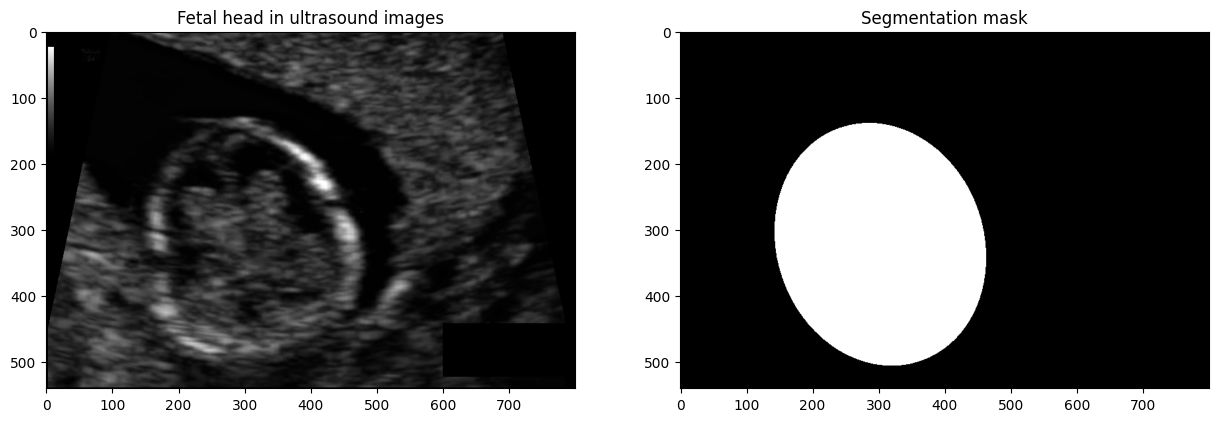

In [5]:
img1 = Image.open("/content/drive/MyDrive/ID5030/training_set/38_HC.png")
img2 = Image.open("/content/drive/MyDrive/ID5030/training_set/38_HC_Annotation.png")

fig = plt.figure(figsize=(15,9))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(img1, cmap='gray')
plt.title('Fetal head in ultrasound images')
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(img2, cmap='gray')
plt.title('Segmentation mask')

plt.show()

# Train-Validation Split

In [ ]:
for f1 in glob.glob('/content/drive/MyDrive/ID5030/training_set/*_Annotation.png'):
    
    img = cv2.imread(f1, cv2.COLOR_BGR2GRAY)
    contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for c in contours:
        ellipse = cv2.fitEllipse(c)
        cv2.ellipse(img, ellipse, (255,255,255), -1)
    
    cv2.imwrite(f1, img)

In [ ]:
source_folder = '/content/drive/MyDrive/ID5030/training_set'
new_folder_1 = '/content/drive/MyDrive/ID5030/train_set'
new_folder_2 = '/content/drive/MyDrive/ID5030/val_set'

In [ ]:
png_files = [file for file in os.listdir(source_folder) if file.endswith('.png')]

In [ ]:
sorted_png_files = sorted(png_files)

In [ ]:
num_train = int(0.8 * len(png_files)) # 80% for train (799)
num_val = len(png_files) - num_train

In [ ]:
for i, png_file in enumerate(png_files):
    if i < num_train:
        file_path = os.path.join(source_folder, sorted_png_files[i])
        shutil.copy2(file_path, new_folder_1)
    
    else:
        file_path = os.path.join(source_folder, sorted_png_files[i])
        shutil.copy2(file_path, new_folder_2)

In [6]:
x_size = (572, 572)
y_size = (575, 575)

In [7]:
class Data_ED(torch.utils.data.Dataset):

    def __init__(self, data, transform=None):

        self.x_train = sorted(glob.glob('/content/drive/MyDrive/ID5030/train_set/*HC.png'))
        self.x_val = sorted(glob.glob('/content/drive/MyDrive/ID5030/val_set/*HC.png'))
        self.x_test = sorted(glob.glob('/content/drive/MyDrive/ID5030/test_set/*HC.png'))
        self.y_train = sorted(glob.glob('/content/drive/MyDrive/ID5030/train_set/*_Annotation.png'))
        self.y_val = sorted(glob.glob('/content/drive/MyDrive/ID5030/val_set/*_Annotation.png'))
        self.data = data

    def __len__(self):

        if(self.data == 'train'):
            return len(self.x_train)

        elif(self.data == 'validate'):
            return len(self.x_val)

        elif(self.data == 'test'):
            return len(self.x_test)

    def __getitem__(self, idx):

        if(self.data == 'train'):
            x = np.array(Image.open(self.x_train[idx]).convert("L").resize(x_size)).reshape(1, 572, 572)
            y = np.array(Image.open(self.y_train[idx]).convert("L").resize(y_size)).reshape(1, 575, 575)
            return torch.from_numpy(x).float(), torch.from_numpy(y).float()

        elif(self.data == 'validate'):
            x = np.array(Image.open(self.x_val[idx]).convert("L").resize(x_size)).reshape(1, 572, 572)
            y = np.array(Image.open(self.y_val[idx]).convert("L").resize(y_size)).reshape(1, 575, 575)
            return torch.from_numpy(x).float(), torch.from_numpy(y).float()

        elif(self.data == 'test'):
            x = np.array(Image.open(self.x_test[idx]).convert("L").resize(x_size)).reshape(1, 572, 572)
            return torch.from_numpy(x).float()

In [8]:
train = Data_ED('train', None)
val = Data_ED('validate', None)
test = Data_ED('test', None)

# Creating the DataLoader

In [9]:
num_epochs = 20
batch_size = 2

In [10]:
train_generator = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True, num_workers=0)
val_generator = torch.utils.data.DataLoader(val, batch_size=2, shuffle=True, num_workers=0)
test_generator = torch.utils.data.DataLoader(test, batch_size=1, shuffle=True, num_workers=0)

# Dice Score

In [11]:
def dice_score(pred, truth):
    num_batches = pred.size(0)
    m1 = pred.view(num_batches, -1).bool()
    m2 = truth.view(num_batches, -1).bool()

    intersection = torch.logical_and(m1, m2).sum(dim=1)
    return (((2. * intersection + 1e-8) / (m1.sum(dim=1) + m2.sum(dim=1) + 1e-8)).sum(dim=0))/2

# Encoder-Decoder Model

![Simple-visualisation-of-Encoder-Decoder-based-CNN-architecture-for-semantic-segmentation.png](attachment:Simple-visualisation-of-Encoder-Decoder-based-CNN-architecture-for-semantic-segmentation.png)

In [12]:
k = [16, 32, 64, 128, 256, 512] # channels

In [13]:
class EncoderDecoder(nn.Module):
    def __init__(self):
        super(EncoderDecoder, self).__init__()
        
        # Encoder layers
        self.encoder_conv1 = nn.Conv2d(1, k[2], 3, padding=1)
        self.encoder_bn1 = nn.BatchNorm2d(k[2])
        self.encoder_relu1 = nn.ReLU(inplace=True)
        self.encoder_pool1 = nn.MaxPool2d(2, stride=2)
        
        self.encoder_conv2 = nn.Conv2d(k[2], k[3], 3, padding=1)
        self.encoder_bn2 = nn.BatchNorm2d(k[3])
        self.encoder_relu2 = nn.ReLU(inplace=True)
        self.encoder_pool2 = nn.MaxPool2d(2, stride=2)
        
        self.encoder_conv3 = nn.Conv2d(k[3], k[4], 3, padding=1)
        self.encoder_bn3 = nn.BatchNorm2d(k[4])
        self.encoder_relu3 = nn.ReLU(inplace=True)
        self.encoder_pool3 = nn.MaxPool2d(2, stride=2)
        
        self.encoder_conv4 = nn.Conv2d(k[4], k[5], 3, padding=1)
        
        # Decoder layers
        self.decoder_convtr1 = nn.ConvTranspose2d(k[5], k[4], 3, stride=2)
        self.decoder_bn1 = nn.BatchNorm2d(k[4])
        self.decoder_relu1 = nn.ReLU(inplace=True)
        self.decoder_conv1 = nn.Conv2d(k[4], k[4], 3, padding=1)
        self.decoder_bn2 = nn.BatchNorm2d(k[4])
        
        self.decoder_convtr2 = nn.ConvTranspose2d(k[4], k[3], 3, stride=2)
        self.decoder_bn3 = nn.BatchNorm2d(k[3])
        self.decoder_relu2 = nn.ReLU(inplace=True)
        self.decoder_conv2 = nn.Conv2d(k[3], k[3], 3, padding=1)
        self.decoder_bn4 = nn.BatchNorm2d(k[3])
        
        self.decoder_convtr3 = nn.ConvTranspose2d(k[3], k[3], 3, stride=2)
        self.decoder_bn5 = nn.BatchNorm2d(k[3])
        self.decoder_relu3 = nn.ReLU(inplace=True)
        self.decoder_conv3 = nn.Conv2d(k[3], 1, 3, padding=1)
        self.decoder_bn6 = nn.BatchNorm2d(1)
        
        self.decoder_sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Encoder
        x = self.encoder_conv1(x)
        x = self.encoder_bn1(x)
        x = self.encoder_relu1(x)
        x = self.encoder_pool1(x)
        
        x = self.encoder_conv2(x)
        x = self.encoder_bn2(x)
        x = self.encoder_relu2(x)
        x = self.encoder_pool2(x)
        
        x = self.encoder_conv3(x)
        x = self.encoder_bn3(x)
        x = self.encoder_relu3(x)
        x = self.encoder_pool3(x)
        
        x = self.encoder_conv4(x)
        
        # Decoder
        x = self.decoder_convtr1(x)
        x = self.decoder_bn1(x)
        x = self.decoder_relu1(x)
        x = self.decoder_conv1(x)
        x = self.decoder_bn2(x)
        
        x = self.decoder_convtr2(x)
        x = self.decoder_bn3(x)
        x = self.decoder_relu2(x)
        x = self.decoder_conv2(x)
        x = self.decoder_bn4(x)
        
        x = self.decoder_convtr3(x)
        x = self.decoder_bn5(x)
        x = self.decoder_relu3(x)
        x = self.decoder_conv3(x)
        x = self.decoder_bn6(x)
        
        x = self.decoder_sigmoid(x)
        
        return x

In [14]:
model = EncoderDecoder().to(device)

loss_train = []
loss_val = []
dice_scores = []

In [15]:
loss_fn = nn.BCELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=9e-2)

train_size = len(train)
val_size = len(val)

In [16]:
for epoch in range(num_epochs):

    running_loss = 0.0
    val_loss = 0.0
    val_acc = 0.0

    # Training
    for data in pyprind.prog_bar(train_generator):
        image, truth = data
        image, truth = image.to(device), truth.to(device)
        truth = truth/255
        predictions = model(image)
        loss = loss_fn(predictions, truth)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    # Validation
    with torch.no_grad():
        for i, data in enumerate(val_generator):
            image, truth = data
            image, truth = image.to(device), truth.to(device)
            truth = truth/255
            predictions = model(image)
            predictions = torch.round(predictions) # Rounding the predictions for classification
            loss = loss_fn(predictions, truth)
            val_loss += loss.item()
            val_acc += dice_score(predictions, truth)*100

    epoch_train_loss = running_loss / (train_size//batch_size+1)
    epoch_val_loss = val_loss / (val_size//batch_size+1)
    epoch_val_acc = val_acc / (val_size//batch_size+1)
    print(f"/// train_loss: {epoch_train_loss} /// val_loss: {epoch_val_loss} /// val_accuracy: {epoch_val_acc}")
    loss_train.append(epoch_train_loss)
    loss_val.append(epoch_val_loss)
    dice_scores.append(epoch_val_acc)

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:02:31


/// train_loss: 0.47099617674946787 /// val_loss: 22.922789299842155 /// val_accuracy: 57.09270095825195


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:02:05


/// train_loss: 0.4208168376237154 /// val_loss: 21.842578632996815 /// val_accuracy: 57.00377655029297


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:02:04


/// train_loss: 0.3975044994801283 /// val_loss: 19.55382737074748 /// val_accuracy: 64.1688003540039


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:02:04


/// train_loss: 0.3898171276599169 /// val_loss: 20.90856662599167 /// val_accuracy: 62.11652755737305


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:02:04


/// train_loss: 0.3770382437109947 /// val_loss: 19.60121436166291 /// val_accuracy: 60.95795440673828


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:02:04


/// train_loss: 0.3616485779359937 /// val_loss: 18.510459163401386 /// val_accuracy: 66.79094696044922


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:02:04


/// train_loss: 0.3538876909390092 /// val_loss: 17.731997839295037 /// val_accuracy: 64.975830078125


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:02:04


/// train_loss: 0.3396860138326883 /// val_loss: 18.17301046730268 /// val_accuracy: 62.869510650634766


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:02:04


/// train_loss: 0.33783640470355747 /// val_loss: 18.20222285242364 /// val_accuracy: 64.05895233154297


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:02:04


/// train_loss: 0.3249838915839791 /// val_loss: 16.019503253521304 /// val_accuracy: 71.0659408569336


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:02:04


/// train_loss: 0.30328843791037796 /// val_loss: 14.209654208457115 /// val_accuracy: 73.18341827392578


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:02:04


/// train_loss: 0.2933410757035017 /// val_loss: 16.014604662904645 /// val_accuracy: 69.22388458251953


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:02:04


/// train_loss: 0.28729525811970236 /// val_loss: 14.524807151001278 /// val_accuracy: 72.87991333007812


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:02:04


/// train_loss: 0.28345866478979587 /// val_loss: 14.67314606373853 /// val_accuracy: 71.33686065673828


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:02:04


/// train_loss: 0.2760908928513527 /// val_loss: 14.221232485063005 /// val_accuracy: 72.93262481689453


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:02:03


/// train_loss: 0.27427566189318897 /// val_loss: 16.331533441449157 /// val_accuracy: 65.11166381835938


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:02:03


/// train_loss: 0.2707062434218824 /// val_loss: 15.069870301992585 /// val_accuracy: 65.93518829345703


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:02:03


/// train_loss: 0.2634857093170285 /// val_loss: 12.157661390776681 /// val_accuracy: 75.69335174560547


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:02:03


/// train_loss: 0.26234993372112514 /// val_loss: 16.058286935976238 /// val_accuracy: 65.35354614257812


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:02:03


/// train_loss: 0.25858118262141944 /// val_loss: 14.332470421743865 /// val_accuracy: 69.90254211425781


### Dice Score for Encoder-Decoder = 69.90

### Train and Validation loss of Encoder-Decoder model

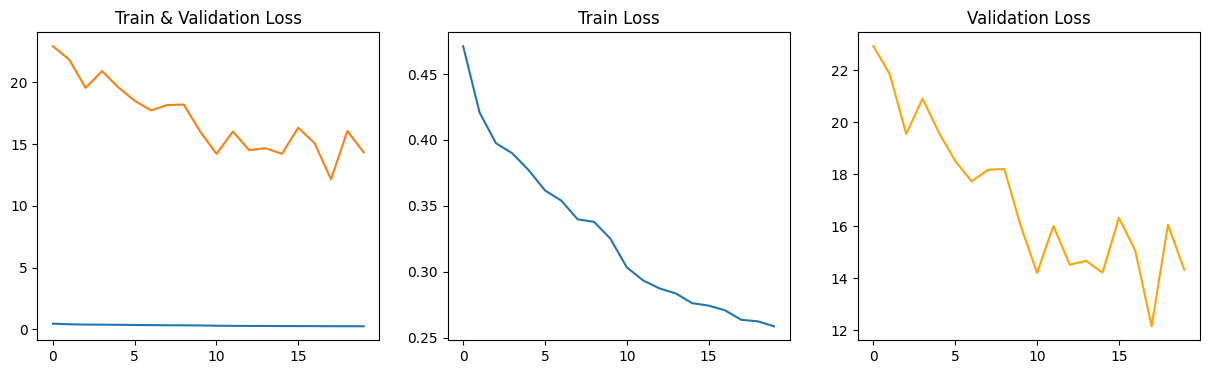

In [22]:
fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(1,3,1)
ax1.plot(loss_train)
ax1.plot(loss_val)
plt.title('Train & Validation Loss')

ax2 = fig.add_subplot(1,3,2)
ax2.plot(loss_train)
plt.title('Train Loss')

ax3 = fig.add_subplot(1,3,3)
ax3.plot(loss_val, c='orange')
plt.title('Validation Loss')

plt.show()

# Performance of Encoder-Decoder on test images

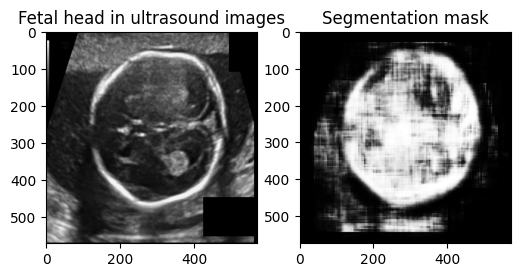

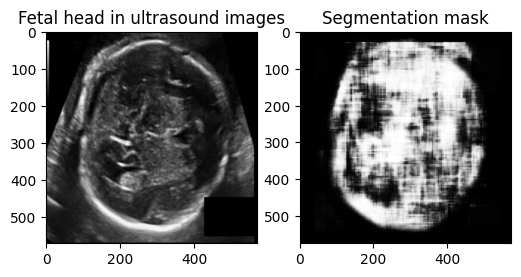

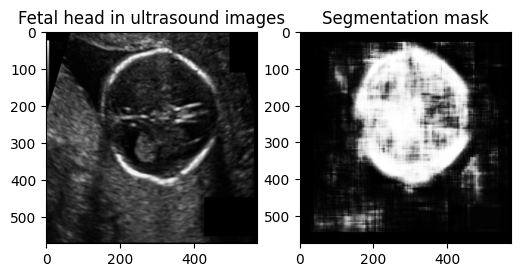

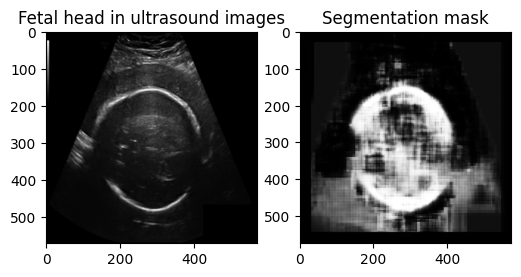

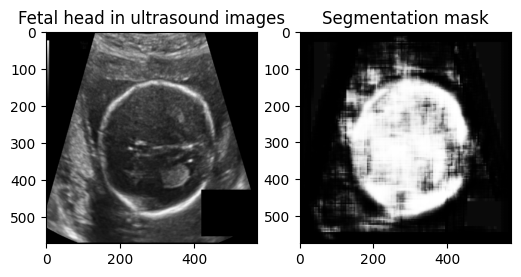

In [25]:
def evaluation_test(test_generator) :
    for i, data in enumerate(test_generator):
        image = data.to(device)
        predictions = model(image)
        break
        
    predictions = 255*predictions   
    tensor = predictions.cpu().detach().numpy().reshape(575, 575)
    tst = data.cpu().detach().numpy().reshape(572, 572)

    fig = plt.figure(figsize=(6,3))
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(tst, cmap='gray')
    plt.title('Fetal head in ultrasound images')
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(tensor, cmap='gray')
    plt.title('Segmentation mask')

    plt.show()

for i in range(5):
    evaluation_test(test_generator)

# Preparing Data-Loader for UNet

In [26]:
x_size = (572, 572)
y_size = (572, 572)

In [27]:
class Data_UNet(torch.utils.data.Dataset):

    def __init__(self, data, transform=None):

        self.x_train = sorted(glob.glob('/content/drive/MyDrive/ID5030/train_set/*HC.png'))
        self.x_val = sorted(glob.glob('/content/drive/MyDrive/ID5030/val_set/*HC.png'))
        self.x_test = sorted(glob.glob('/content/drive/MyDrive/ID5030/test_set/*HC.png'))
        self.y_train = sorted(glob.glob('/content/drive/MyDrive/ID5030/train_set/*_Annotation.png'))
        self.y_val = sorted(glob.glob('/content/drive/MyDrive/ID5030/val_set/*_Annotation.png'))
        self.data = data

    def __len__(self):

        if(self.data == 'train'):
            return len(self.x_train)

        elif(self.data == 'validate'):
            return len(self.x_val)

        elif(self.data == 'test'):
            return len(self.x_test)

    def __getitem__(self, idx):

        if(self.data == 'train'):
            x = np.array(Image.open(self.x_train[idx]).convert("L").resize(x_size)).reshape(1, 572, 572)
            y = np.array(Image.open(self.y_train[idx]).convert("L").resize(y_size)).reshape(1, 572, 572)
            return torch.from_numpy(x).float(), torch.from_numpy(y).float()

        elif(self.data == 'validate'):
            x = np.array(Image.open(self.x_val[idx]).convert("L").resize(x_size)).reshape(1, 572, 572)
            y = np.array(Image.open(self.y_val[idx]).convert("L").resize(y_size)).reshape(1, 572, 572)
            return torch.from_numpy(x).float(), torch.from_numpy(y).float()

        elif(self.data == 'test'):
            x = np.array(Image.open(self.x_test[idx]).convert("L").resize(x_size)).reshape(1, 572, 572)
            return torch.from_numpy(x).float()

In [28]:
train = Data_UNet('train', None)
val = Data_UNet('validate', None)
test = Data_UNet('test', None)

In [29]:
num_epochs = 10
batch_size = 2

In [30]:
train_generator = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True, num_workers=0)
val_generator = torch.utils.data.DataLoader(val, batch_size=2, shuffle=True, num_workers=0)
test_generator = torch.utils.data.DataLoader(test, batch_size=1, shuffle=True, num_workers=0)

# UNet Model

![173041942-a7c3e072-060d-4e87-9e91-0f6f9396e585.png](attachment:173041942-a7c3e072-060d-4e87-9e91-0f6f9396e585.png)

In [31]:
k = [64, 128, 256, 512, 1024] # channels

In [32]:
class conv_skp(nn.Module):

    def __init__(self, input_channels, output_channels, down=True):
        super(conv_skp, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(output_channels),
                                   nn.ReLU(inplace = True),
                                   nn.Dropout(0.5),)
        self.conv2 = nn.Sequential(nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(output_channels),
                                   nn.ReLU(inplace = True),
                                   nn.Dropout(0.5),)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)+x1
        return x2

class start_conv(nn.Module):

    def __init__(self, input_channels, output_channels):
        super(start_conv, self).__init__()
        self.conv = conv_skp(input_channels, output_channels)

    def forward(self, x):
        x = self.conv(x)
        return x

class down_conv(nn.Module):

    def __init__(self, input_channels, output_channels):
        super(down_conv, self).__init__()
        self.conv = nn.Sequential(nn.MaxPool2d(2),
                                  conv_skp(input_channels, output_channels),)
    def forward(self,x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):

    def __init__(self, input_channels, output_channels):
        super(up_conv, self).__init__()
        self.up = nn.ConvTranspose2d(input_channels//2, input_channels//2, kernel_size=2, stride=2)
        self.conv = conv_skp(input_channels, output_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diff1 = x2.shape[2]-x1.shape[2]
        diff2 = x2.shape[3]-x1.shape[3]
        x1 = F.pad(x1, pad=(diff1//2, diff1-diff1//2, diff2//2, diff2-diff2//2))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

class stop_conv(nn.Module):

    def __init__(self, input_channels, output_channels):
        super(stop_conv, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(input_channels, output_channels, kernel_size=1),
                                 nn.Sigmoid())

    def forward(self, x):
        x = self.conv(x)
        return x

class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()

        self.inc = start_conv(1, k[0])
        self.down1 = down_conv(k[0], k[1])
        self.down2 = down_conv(k[1], k[2])
        self.down3 = down_conv(k[2], k[3])
        self.down4 = down_conv(k[3], k[3])
        self.up1 = up_conv(k[4], k[2])
        self.up2 = up_conv(k[3], k[1])
        self.up3 = up_conv(k[2], k[0])
        self.up4 = up_conv(k[1], k[0])
        self.outc = stop_conv(k[0], 1)

    def forward(self, x):

        xin = self.inc(x)
        xd1 = self.down1(xin)
        xd2 = self.down2(xd1)
        xd3 = self.down3(xd2)
        xd4 = self.down4(xd3)
        xu1 = self.up1(xd4, xd3)
        xu2 = self.up2(xu1, xd2)
        xu3 = self.up3(xu2, xd1)
        xu4 = self.up4(xu3, xin)
        xout = self.outc(xu4)
        return xout

In [33]:
model = Unet().to(device)

loss_train_unet = []
loss_val_unet = []
dice_scores_unet = []

# Dice Loss

In [34]:
def dice_score(pred, truth):
    num_batches = pred.size(0)
    m1 = pred.view(num_batches, -1).bool()
    m2 = truth.view(num_batches, -1).bool()

    intersection = torch.logical_and(m1, m2).sum(dim=1)
    return (((2. * intersection + 1e-8) / (m1.sum(dim=1) + m2.sum(dim=1) + 1e-8)).sum(dim=0))/2

In [35]:
loss_fn = nn.BCELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=5e-3)

train_size = len(train)
val_size = len(val)

# Training

In [36]:
for epoch in range(num_epochs):

    running_loss = 0.0
    val_loss = 0.0
    val_acc = 0.0

    # Training
    for data in pyprind.prog_bar(train_generator):
        image, truth = data
        image, truth = image.to(device), truth.to(device)
        truth = truth/255
        predictions = model(image)
        loss = loss_fn(predictions, truth)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    # Validation
    with torch.no_grad():
        for i, data in enumerate(val_generator):
            image, truth = data
            image, truth = image.to(device), truth.to(device)
            truth = truth/255
            predictions = model(image)
            predictions = torch.round(predictions) # Rounding the predictions for classification
            loss = loss_fn(predictions, truth)
            val_loss += loss.item()
            val_acc += dice_score(predictions, truth)*100

    epoch_train_loss = running_loss / (train_size//batch_size+1)
    epoch_val_loss = val_loss / (val_size//batch_size+1)
    epoch_val_acc = val_acc / (val_size//batch_size+1)
    print(f"/// train_loss: {epoch_train_loss} /// val_loss: {epoch_val_loss} /// dice_score: {epoch_val_acc}")
    loss_train_unet.append(epoch_train_loss)
    loss_val_unet.append(epoch_val_loss)
    dice_scores_unet.append(epoch_val_acc)

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:03:32


/// train_loss: 0.344486633092165 /// val_loss: 12.324052078889148 /// dice_score: 76.38130187988281


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:03:36


/// train_loss: 0.20311192827299238 /// val_loss: 11.870624981304207 /// dice_score: 76.51715850830078


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:03:41


/// train_loss: 0.14861782452091574 /// val_loss: 9.227156230718782 /// dice_score: 81.11157989501953


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:03:41


/// train_loss: 0.12452638424001634 /// val_loss: 8.463671443485978 /// dice_score: 83.00471496582031


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:03:41


/// train_loss: 0.10493214575108141 /// val_loss: 5.058533736974886 /// dice_score: 89.81084442138672


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:03:41


/// train_loss: 0.08672378559131175 /// val_loss: 6.340067280401097 /// dice_score: 86.72272491455078


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:03:41


/// train_loss: 0.08767584219109267 /// val_loss: 5.298091160188807 /// dice_score: 89.04149627685547


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:03:41


/// train_loss: 0.08121331475209445 /// val_loss: 4.8286909986250475 /// dice_score: 89.86539459228516


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:03:42


/// train_loss: 0.0768243304407224 /// val_loss: 5.230517333096797 /// dice_score: 88.9073486328125


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:03:41


/// train_loss: 0.07382758012972772 /// val_loss: 4.508988378071549 /// dice_score: 90.58123016357422


### Dice score of UNet = 90.58

### Train and Validation loss of UNet model

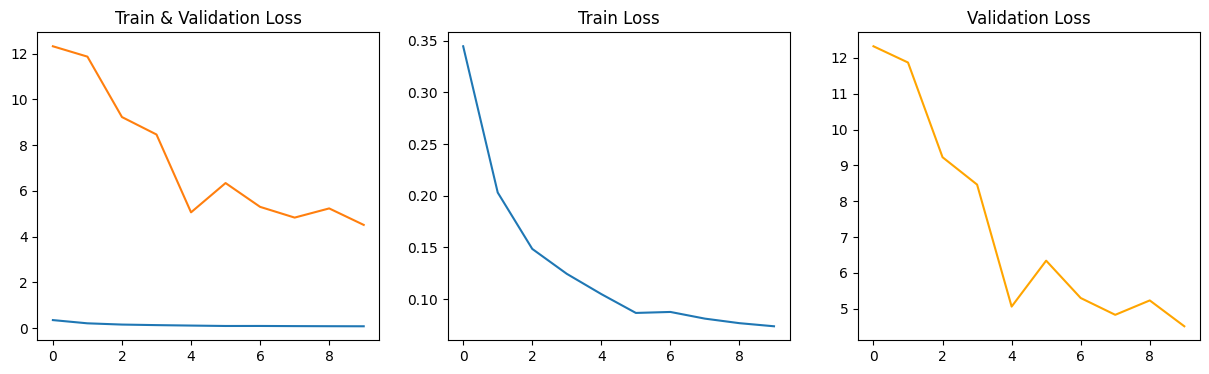

In [37]:
fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(1,3,1)
ax1.plot(loss_train_unet)
ax1.plot(loss_val_unet)
plt.title('Train & Validation Loss')

ax2 = fig.add_subplot(1,3,2)
ax2.plot(loss_train_unet)
plt.title('Train Loss')

ax3 = fig.add_subplot(1,3,3)
ax3.plot(loss_val_unet, c='orange')
plt.title('Validation Loss')

plt.show()

# Comparison of Dice scores

- **We can observe that the ```dice score``` of the ```UNet``` model is higher than that of the plain ```Encoder-Decoder``` model**
- **This is because the UNet architecture has skip connections that allow for better preservation of spatial information across different layers of the network.**
- **This, in turn, allows the model to capture more detailed features and better segment objects in the image.**

# Performance of UNet on test images

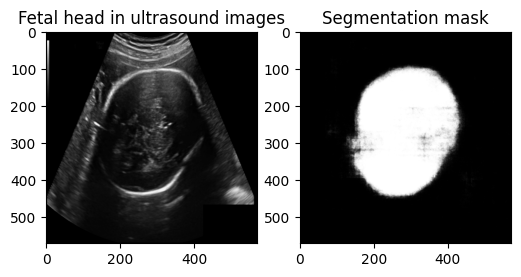

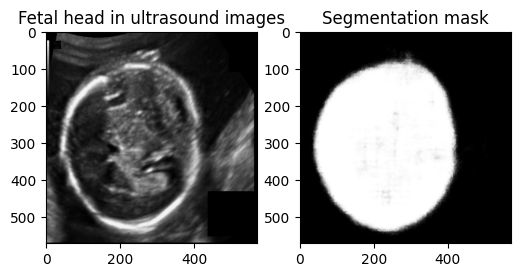

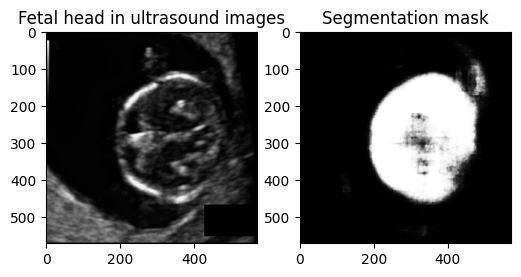

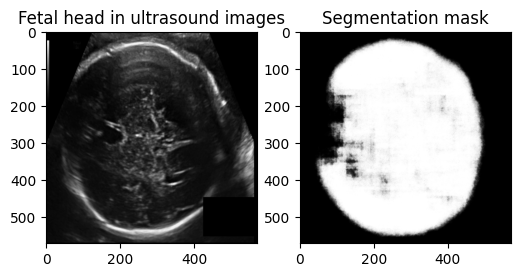

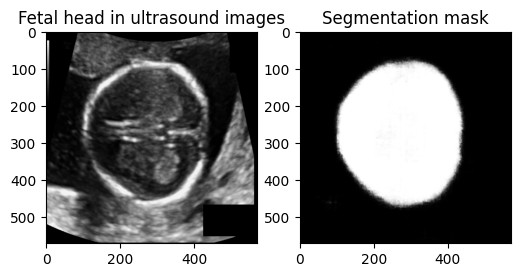

In [42]:
def evaluation_test_unet(test_generator):
    for data in test_generator:
        image = data.to(device)
        predictions = model(image)
        break
        
    predictions = 255*predictions   
    tensor = predictions.cpu().detach().numpy().reshape(572, 572)
    tst = data.detach().cpu().numpy().reshape(572, 572)

    fig = plt.figure(figsize=(6,3))
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(tst, cmap='gray')
    plt.title('Fetal head in ultrasound images')
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(tensor, cmap='gray')
    plt.title('Segmentation mask')

    plt.show()

for i in range(5):
    evaluation_test_unet(test_generator)

$$
Thank You
$$